In [44]:
%load_ext autoreload
%autoreload 2

from tweedejaars_project import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import *
from sklearn import metrics

df = load_df()

version = "target"
target = "fix_two_sided_ptu"
train_set = "train"
test_set = "valid"
df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,datetime,import_capacity,upward_dispatch_published,downward_dispatch_published,min_price_published,mid_price_published,max_price_published,minute_in_ptu,min_ptu_price_known,max_ptu_price_known,...,forecast_solar,forecast_demand,ptu_id,target_two_sided_ptu_alt,target_two_sided_ptu_realtime,target_two_sided_ptu_flip,fix_two_sided_ptu,fix_two_sided_ptu_alt,fix_two_sided_ptu_realtime,fix_two_sided_ptu_flip
0,2023-12-29 00:00:00+00:00,65.4,0.0,0.0,0.00,0.00,0.00,0,NaN,NaN,...,0.0,10927.409665,0,True,True,True,False,True,True,True
1,2023-12-29 00:01:00+00:00,65.4,0.0,0.0,0.00,0.00,0.00,1,NaN,NaN,...,0.0,10927.409665,0,True,False,False,False,True,False,False
2,2023-12-29 00:02:00+00:00,65.4,0.0,79.0,-8.81,33.59,NaN,2,-8.81,NaN,...,0.0,10927.409665,0,True,False,False,True,True,False,False
3,2023-12-29 00:03:00+00:00,65.4,0.0,61.0,-8.81,33.59,NaN,3,-8.81,NaN,...,0.0,10927.409665,0,True,False,False,True,True,False,False
4,2023-12-29 00:04:00+00:00,65.4,0.0,43.0,-8.81,33.59,NaN,4,-8.81,NaN,...,0.0,10927.409665,0,True,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220241,2024-05-29 22:41:00+00:00,1982.6,167.0,0.0,NaN,80.12,96.92,11,NaN,101.22,...,0.0,11649.839443,14682,False,False,False,False,False,False,False
220242,2024-05-29 22:42:00+00:00,1982.6,165.0,0.0,NaN,80.12,96.92,12,NaN,101.22,...,0.0,11649.839443,14682,False,False,False,False,False,False,False
220243,2024-05-29 22:43:00+00:00,1982.6,162.0,0.0,NaN,80.12,96.87,13,NaN,101.22,...,0.0,11649.839443,14682,False,False,False,False,False,False,False
220244,2024-05-29 22:44:00+00:00,1982.6,158.0,0.0,NaN,80.12,96.87,14,NaN,101.22,...,0.0,11649.839443,14682,False,False,False,False,False,False,False


In [33]:
df['residual_load'] = df['forecast_demand'] - df['forecast_solar'] - df['forecast_wind']
df['forecast_solar_delta'] = df['forecast_solar'].diff()
df['forecast_wind_delta'] = df['forecast_wind'].diff()
for i in range(0, len(df), 15):
    df.loc[i+1:i+14, 'forecast_solar_delta'] = df['forecast_solar_delta'][i]
    df.loc[i+1:i+14, 'forecast_wind_delta'] = df['forecast_wind_delta'][i]
# diffs
df['min_price_diff'] = df['min_price_published'].diff() + df['min_price_published']
df['downward_dispatch_diff'] = df['downward_dispatch_published'].diff() + df['downward_dispatch_published']
df['igcc_down_diff'] = df['igcc_contribution_down_published'].diff() + df['igcc_contribution_down_published']
df['downward_dispatch_diff_2'] = df['downward_dispatch_published'].diff(periods=2) + df['downward_dispatch_published']
df['downward_dispatch_diff_3'] = df['downward_dispatch_published'].diff(periods=3) + df['downward_dispatch_published']
df['dispatch_diff'] = df['upward_dispatch_published'] - df['downward_dispatch_published']
df['igcc_diff'] = df['igcc_contribution_up_published'] - df['igcc_contribution_down_published']
df['import_zero'] = df['import_capacity'] == 0
df['import_capacity_left'] = df['import_capacity'] + df['igcc_contribution_down_published'] - df['igcc_contribution_up_published']

In [47]:
def peak_features(df,feature,negative=False):
    if negative:
        df[f'{feature}_peak'] = (df[feature] >= df[feature].shift(1)) & (df[feature].shift(1) < df[feature].shift(2))
    else:
        df[f'{feature}_peak'] = (df[feature] <= df[feature].shift(1)) & (df[feature].shift(1) > df[feature].shift(2))

    df[f'{feature}_peak_time'] = df[f'{feature}_peak'].cumsum()
    df[f'{feature}_peak_time'] = df.groupby(f'{feature}_peak_time').cumcount() + 1

    df['peak_values'] = np.where(df[f'{feature}_peak'], df[feature].shift(1), np.nan)
    df['peak_values'] = df['peak_values'].ffill()
    df[f'{feature}_peak_diff'] = df[feature] - df['peak_values'].ffill()

def add_peak_features(df):
    peak_features(df,'downward_dispatch_published')
    peak_features(df,'upward_dispatch_published')
    peak_features(df,'igcc_contribution_down_published')
    peak_features(df,'igcc_contribution_up_published')
    peak_features(df,'min_price_published',negative=True)
    peak_features(df,'max_price_published')
    return df


peak_features(df,'downward_dispatch_published')
peak_features(df,'upward_dispatch_published')
peak_features(df,'igcc_contribution_down_published')
peak_features(df,'igcc_contribution_up_published')

count    50.000000
mean      0.014758
std       0.008142
min      -0.005074
25%       0.009086
50%       0.015886
75%       0.020291
max       0.030107
Name: 0, dtype: float64
0.030106657048489718


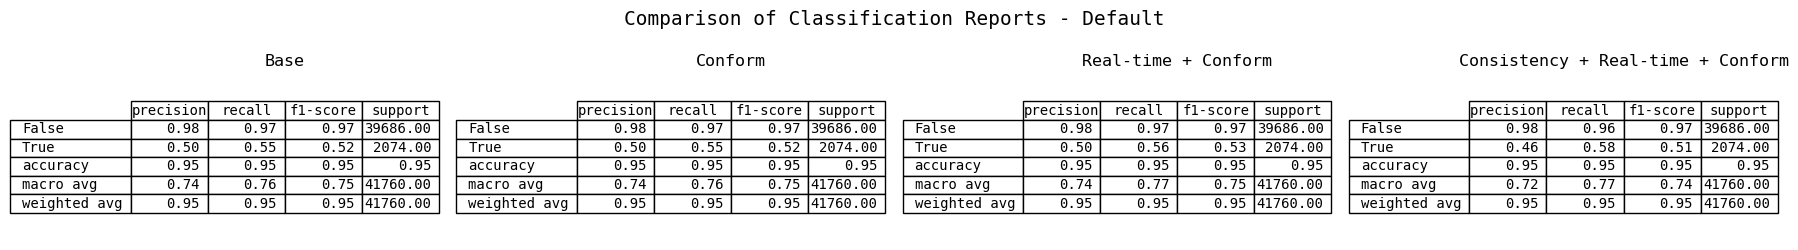

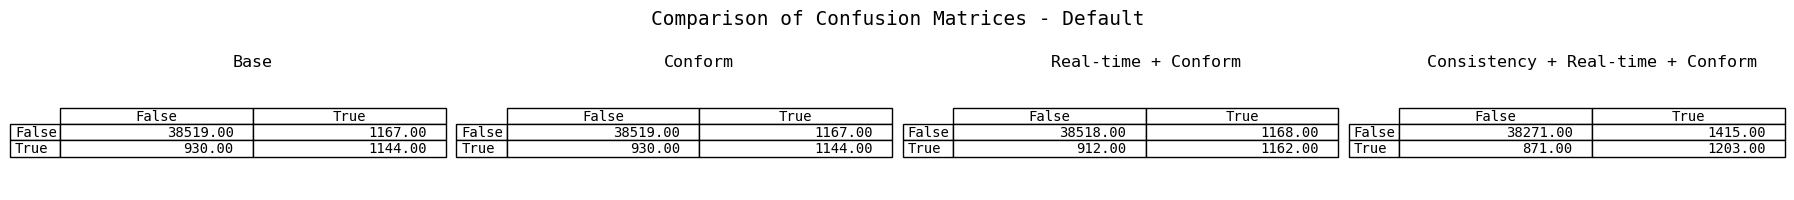

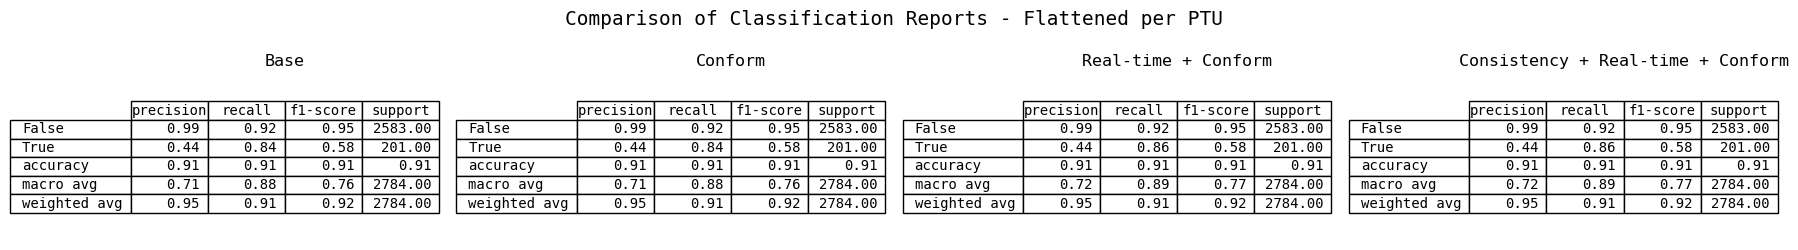

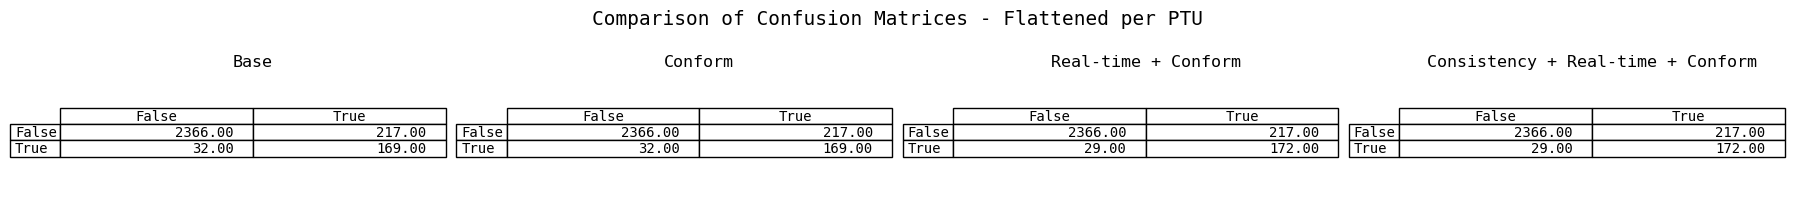

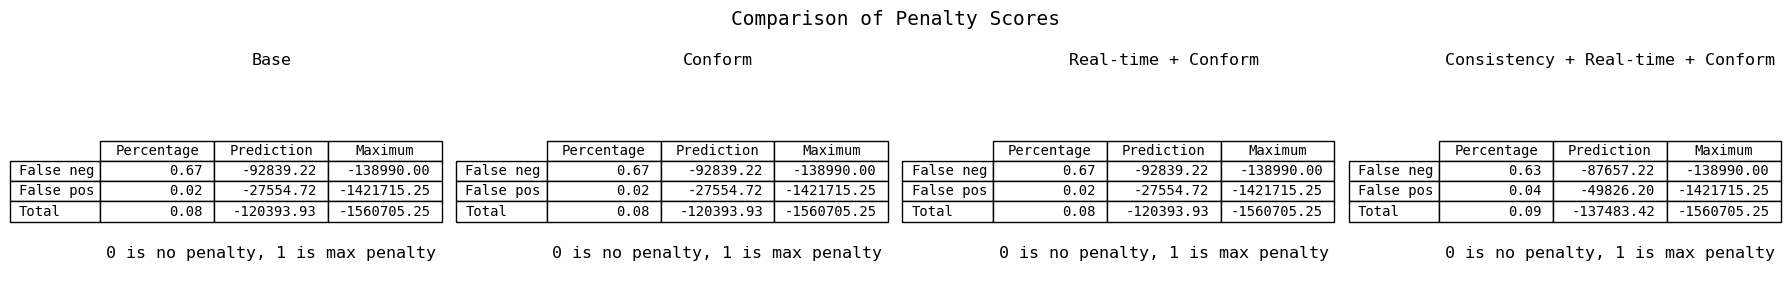

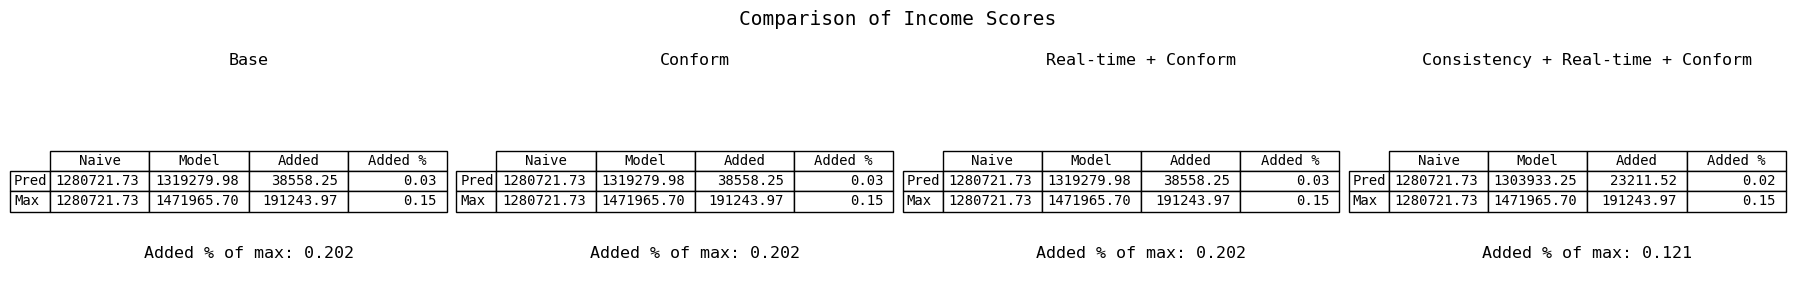

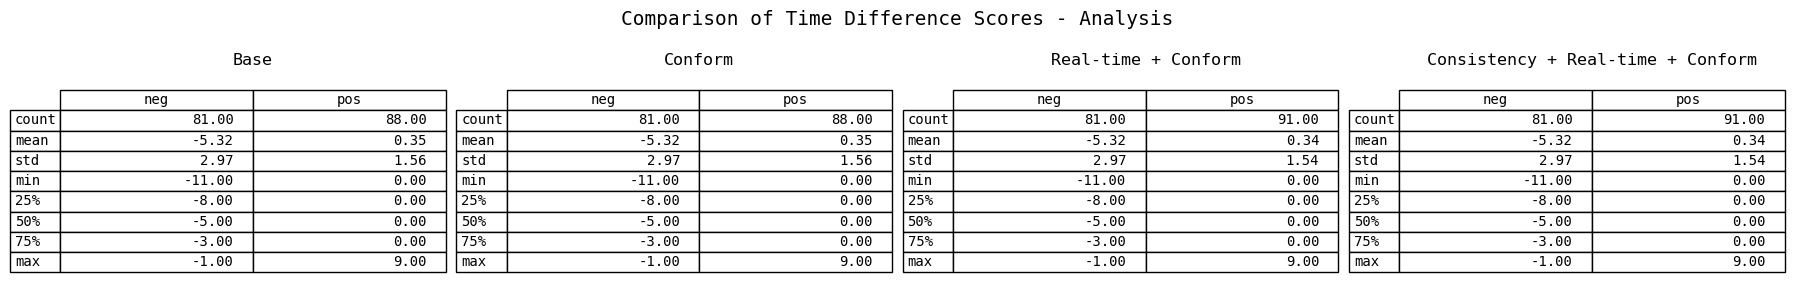

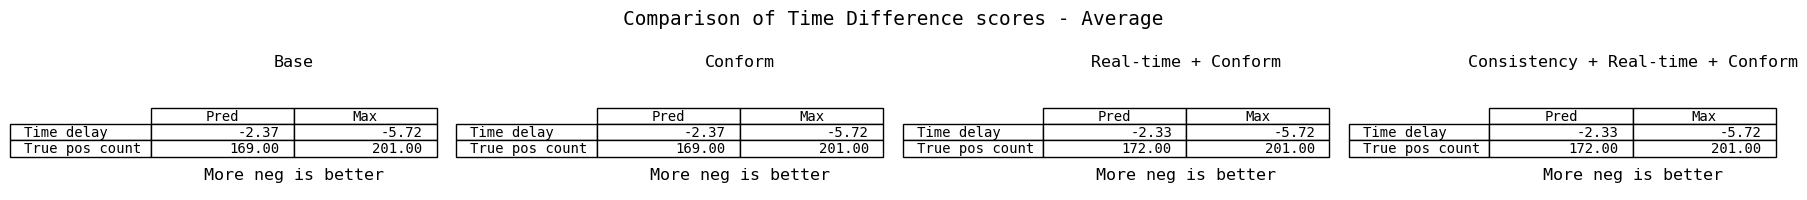

In [39]:
features = [
    "import_capacity",
    "min_price_published",
    "mid_price_published",
    "max_price_published",
    "min_ptu_price_known",
    "max_ptu_price_known",
    "time_since_last_two_sided",
    "two_sided_daily_count",
    "PTU",
    "naive_strategy_action",
    "vwap_avg",
    "vwap_std",
    "vwap_median",
    "vwap_qty_sum",
    "hvq_delta",
    "forecast_wind",
    "forecast_solar",
    "forecast_demand",
    'residual_load',
    'forecast_solar_delta',
    'forecast_wind_delta',
    'downward_dispatch_diff',
    'downward_dispatch_diff_2',
    'downward_dispatch_diff_3',
    'igcc_down_diff',
    'dispatch_diff',
    'igcc_diff',
    'import_zero',
    'import_capacity_left',
    'downward_dispatch_peak',
    'downward_dispatch_peak_time',
    'downward_dispatch_peak_diff',
    'upward_dispatch_peak',
    'upward_dispatch_peak_time',
    'upward_dispatch_peak_diff',
    'igcc_down_peak',
    'igcc_down_peak_time',
    'igcc_down_peak_diff',
    'igcc_up_peak',
    'igcc_up_peak_time',
    'igcc_up_peak_diff',
]
splits = get_splits(df, features, target, return_dict_pair=False)
# m = RandomForestClassifier(n_estimators=50)
# model = HistGradientBoostingRegressor(loss="poisson", l2_regularization=8, learning_rate=0.2, validation_fraction=0.5)



def train(train_in, train_out):
    model = HistGradientBoostingRegressor(loss="poisson", l2_regularization=8, learning_rate=0.2, validation_fraction=0.5)
    model.fit(train_in, train_out)
    return model


def test(model, test_in):
    pred = model.predict(test_in)
    return recast_pred(pred > 0.5)


best, _ = evaluate_income(train, test, splits[train_set][0], splits[train_set][1], splits[test_set][0], splits[test_set][3], repeat=50)

print(best[1])
p1 = test(best[0], splits[test_set][0])
show_metrics_adjusted(splits[test_set][3], p1, version=version)




# train on fix test on target
# split target and two side
# only check ptu start with neg or naive=true, for train or metric

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[False False False ... False False False]


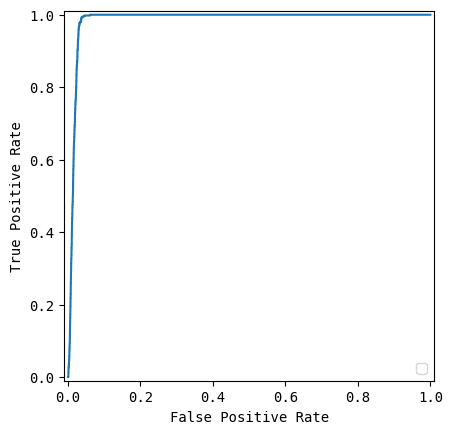

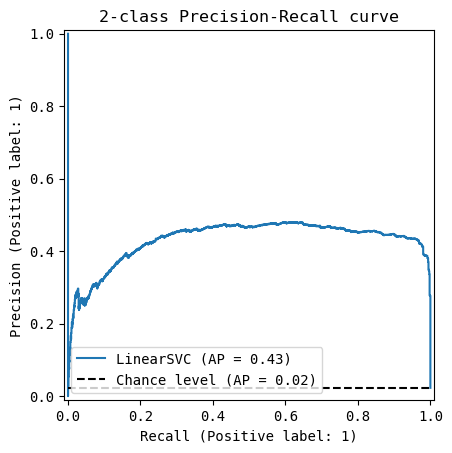

In [40]:
realtime = splits[test_set][3]['target_two_sided_ptu_realtime'].to_numpy(copy=True)

print(realtime)
fpr, tpr, thresholds = metrics.roc_curve(realtime, best[0].predict(splits[test_set][0]), pos_label=1)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

precision, recall, thresholds = metrics.precision_recall_curve(realtime, best[0].predict(splits[test_set][0]), pos_label=1)
display = metrics.PrecisionRecallDisplay.from_predictions(
    realtime, best[0].predict(splits[test_set][0]), name="LinearSVC", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

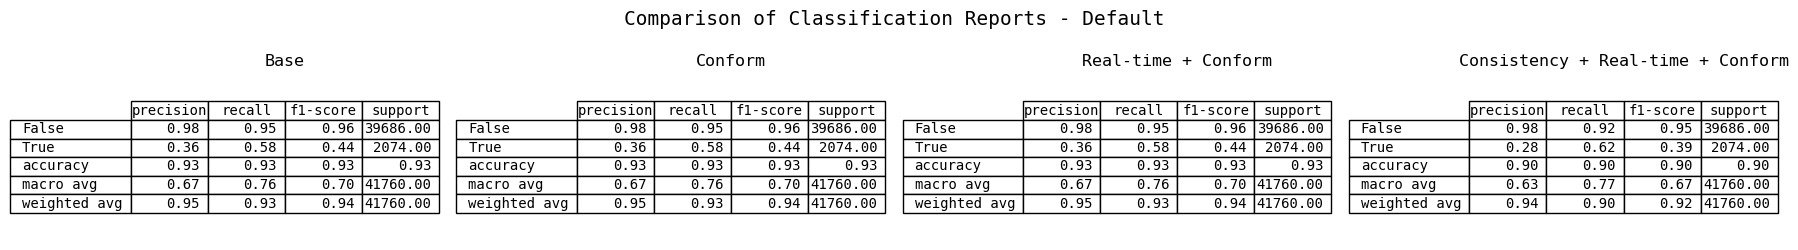

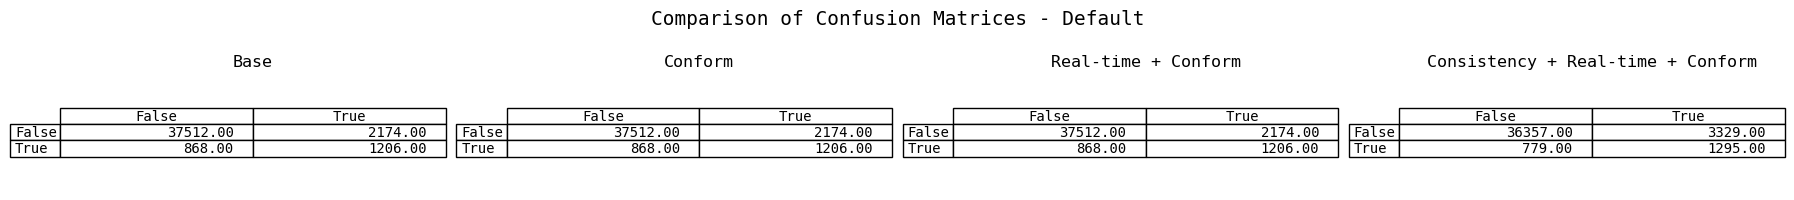

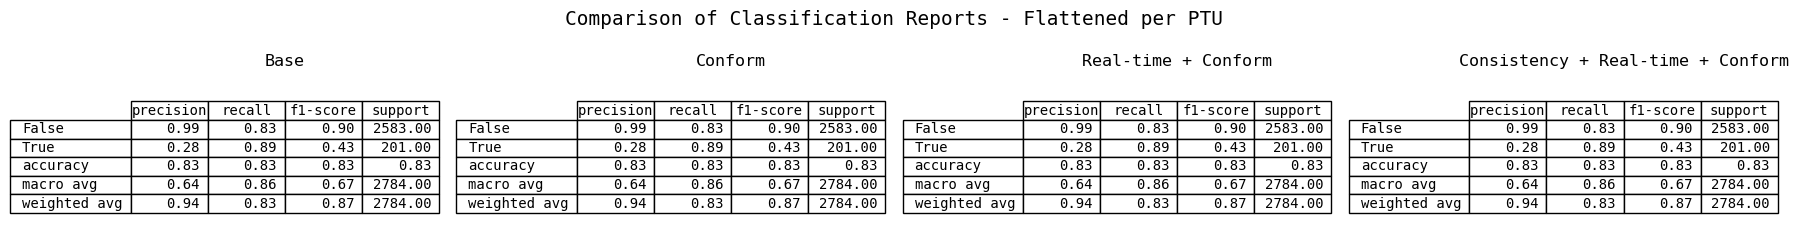

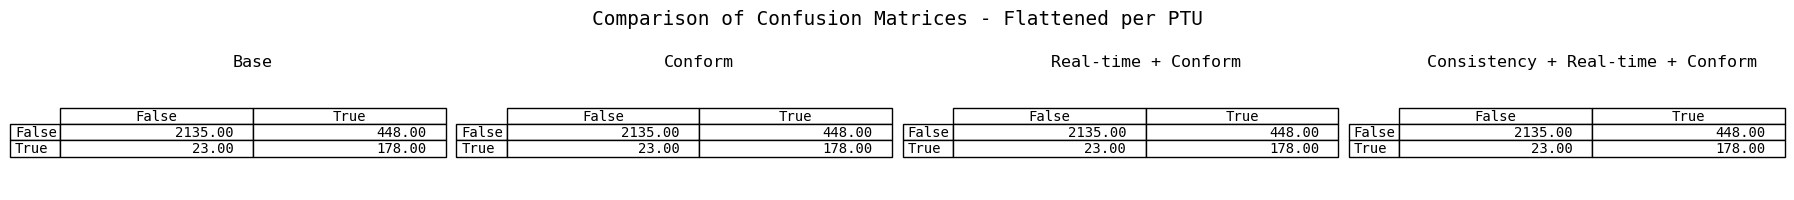

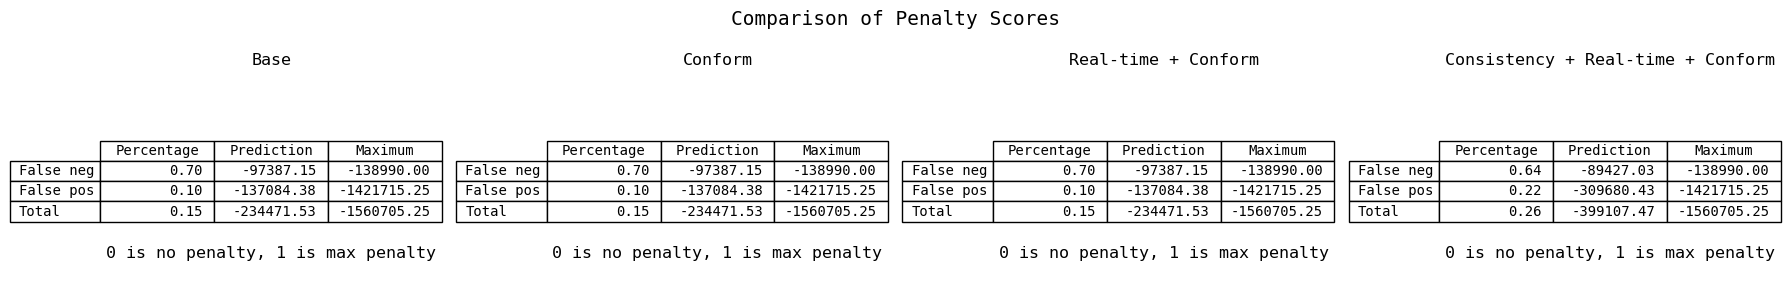

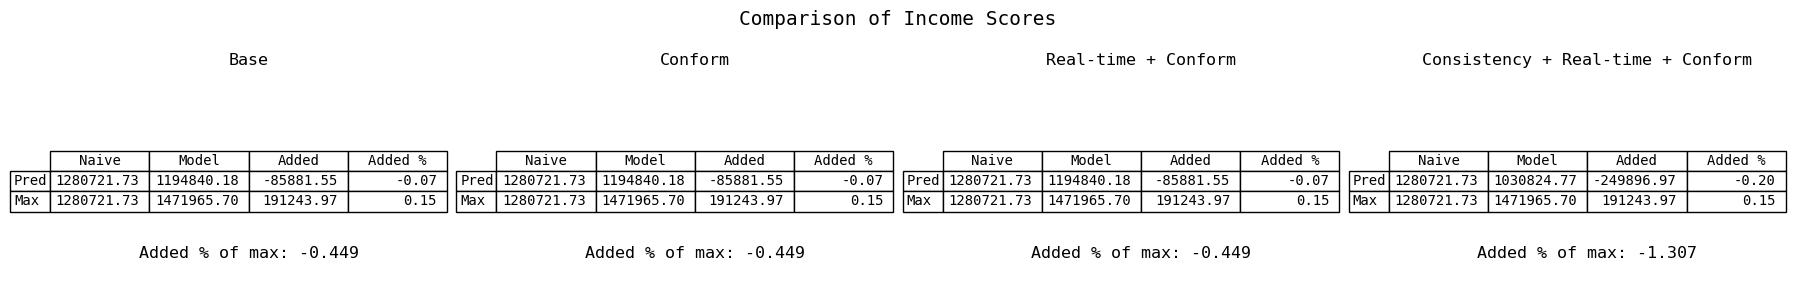

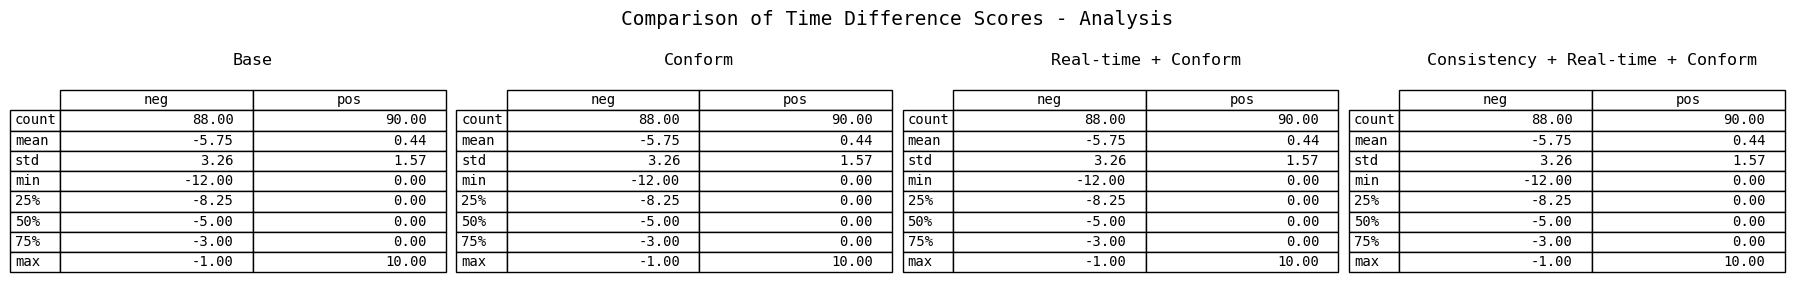

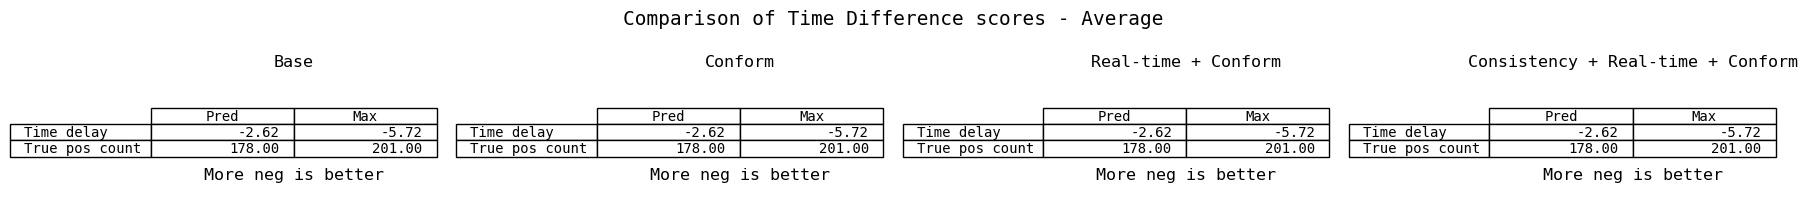

In [41]:
features = ["mid_price_published", "minute_in_ptu", "time_since_last_two_sided",
       "vwap_avg", "PTU", "forecast_demand", "ptu_id", "residual_load",
       "dispatch_diff", "igcc_diff"]
splits = get_splits(df, features, target, return_dict_pair=False)
# m = RandomForestClassifier(n_estimators=50)
# m = HistGradientBoostingRegressor(loss="poisson", l2_regularization=4)
m = HistGradientBoostingClassifier()
m.fit(splits[train_set][0], splits[train_set][1])
p = m.predict(splits[test_set][0])
# p = p > 0.5
p2 = recast_pred(p)
show_metrics_adjusted(splits[test_set][3], p2, version=version)

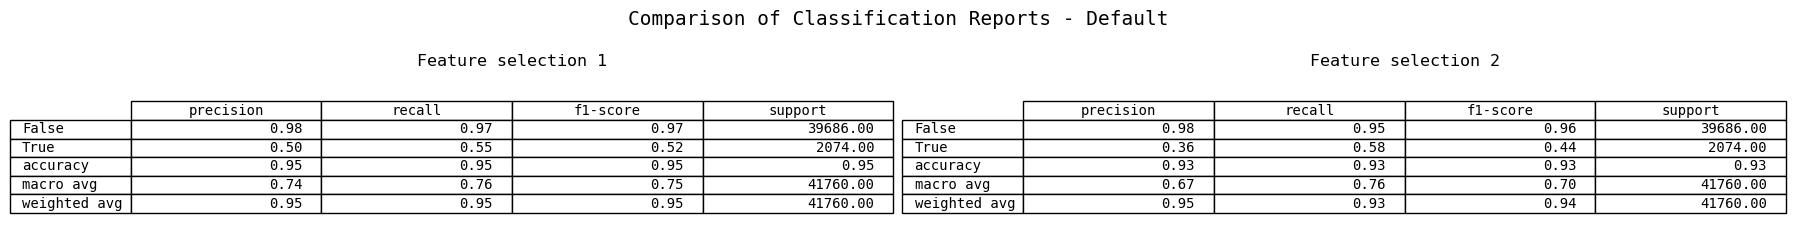

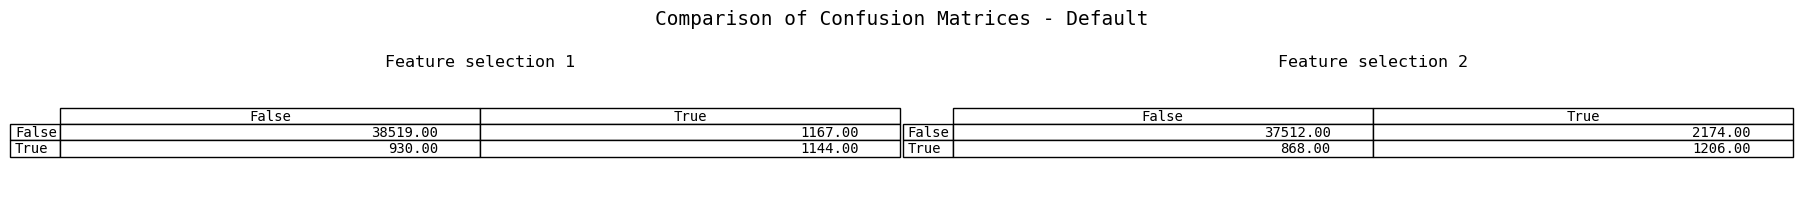

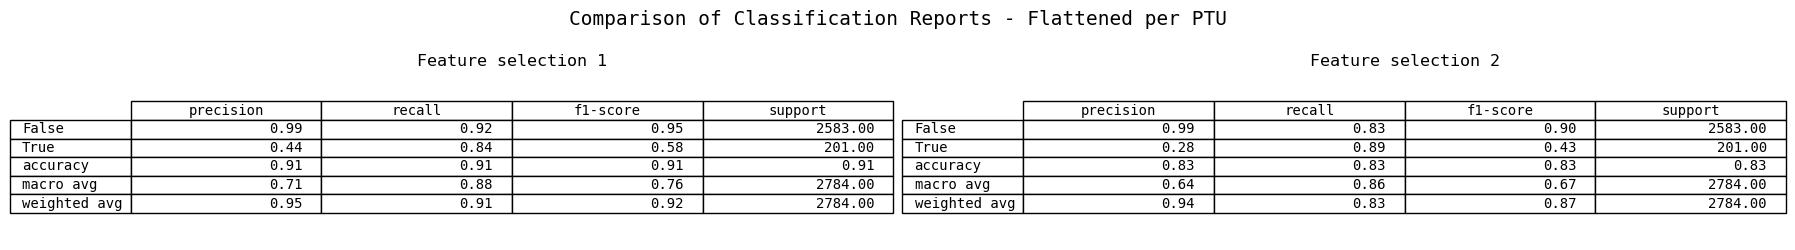

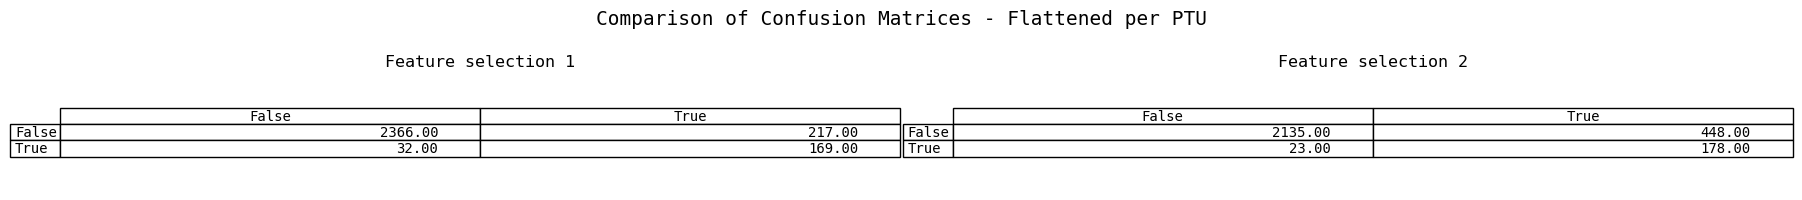

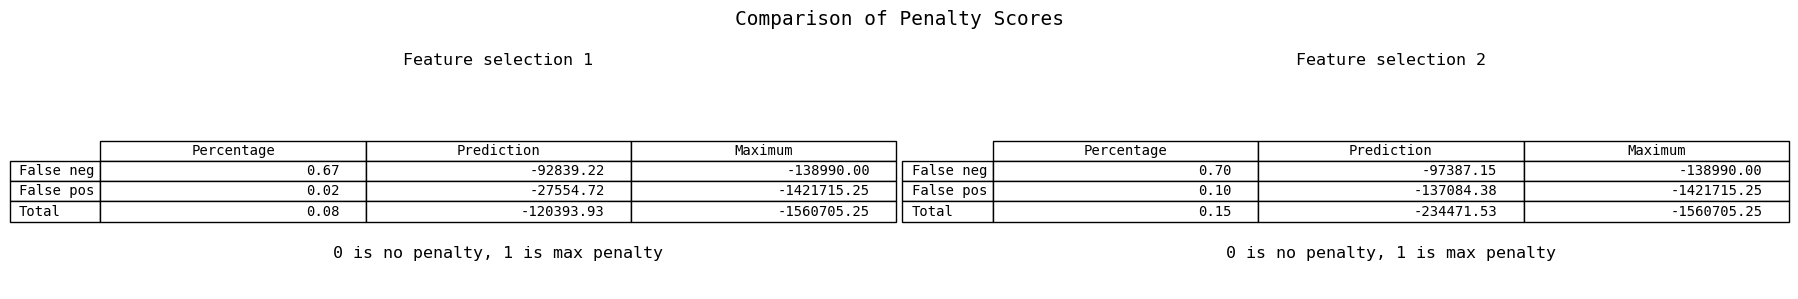

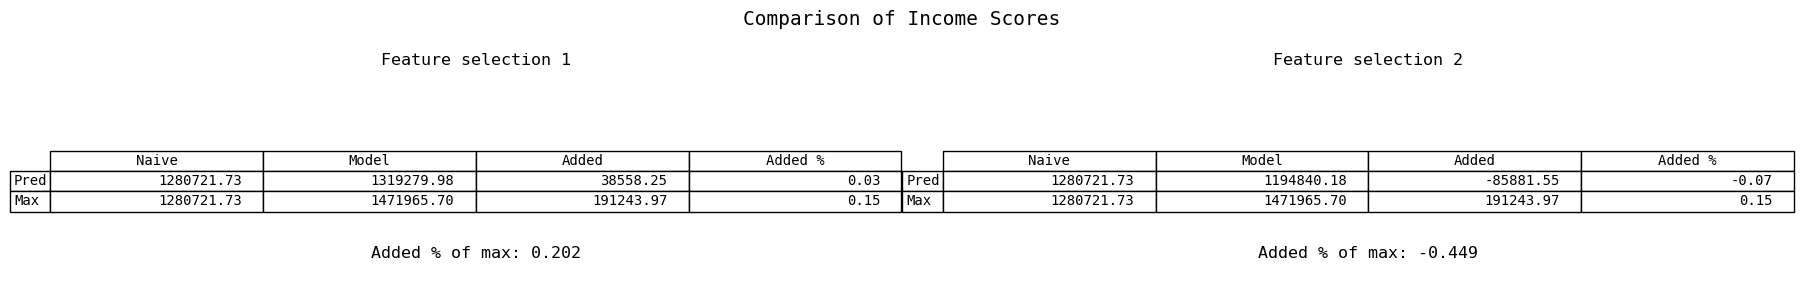

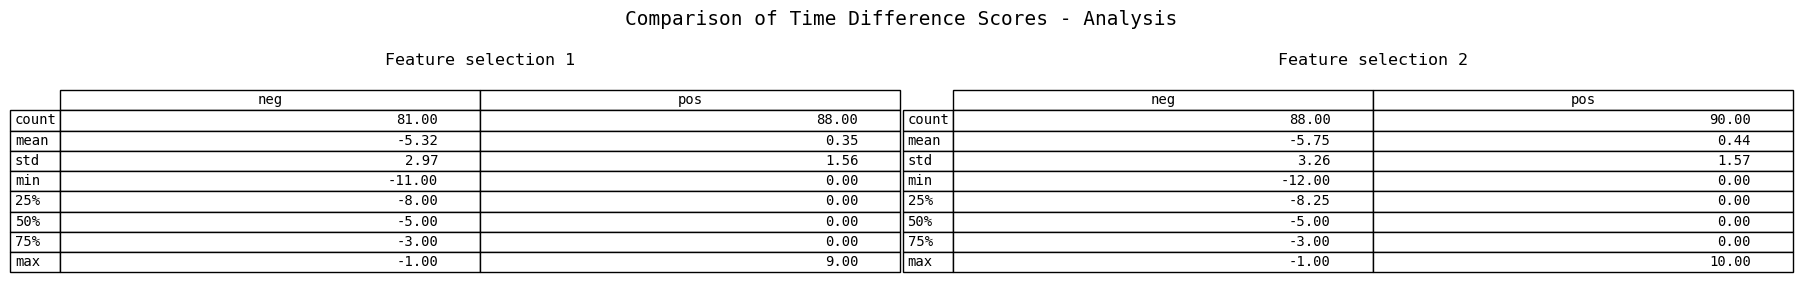

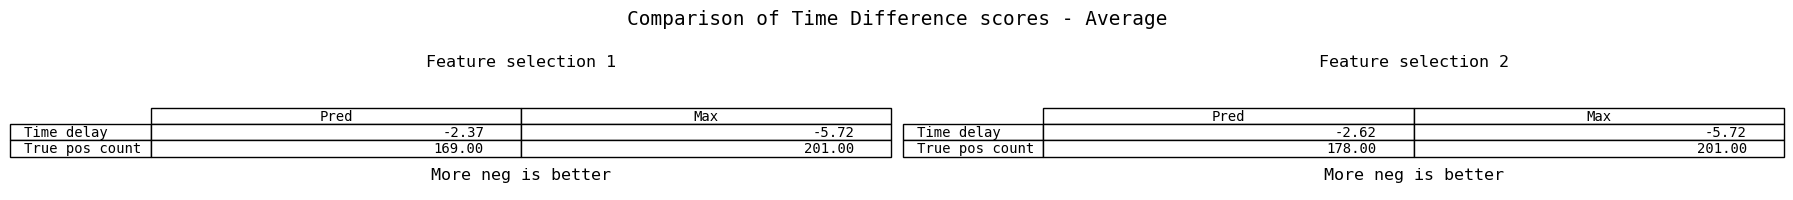

In [42]:
show_metrics_multi(splits[test_set][3], [p1, p2], titles=["Feature selection 1", "Feature selection 2"], version=version)